In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
filename = "cg-X_9339x224x224x3.npy"
if not os.path.exists(filename):
    print("Saving file %s ..." %(filename))
    np.save(filename, X)

Saving file cg-X_9339x224x224x3.npy ...


In [7]:
filename = "cg-y_numclass.npy"
if not os.path.exists(filename):
    print("Saving file %s ..." %(filename))
    np.save(filename, y)

Saving file cg-y_numclass.npy ...


In [8]:
filename = "cg-Y_onehotencode.npy"
if not os.path.exists(filename):
    print("Saving file %s ..." %(filename))
    np.save(filename, Y)

Saving file cg-Y_onehotencode.npy ...


In [9]:
# Creating base model (VGG16 convolutional layers)
img_shape = (224, 224, 3)                                                                                                                                               
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=img_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])       

In [10]:
vgg16weights = "vgg16_weights_tf_dim_ordering_tf_kernels.h5"
model.load_weights(vgg16weights, by_name=True)

In [11]:
filename = 'cg-vgg16features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vggfeatures = np.load(filename)
else:
    print("Extracting features from VGG16 convolutional layers ...")
    vggfeatures = model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vggfeatures)

Extracting features from VGG16 convolutional layers ...
Saving VGG16 extracted features into cg-vgg16features.npy ...


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Training top_model and saving min training loss weights
num_epochs=200
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-200epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = vggfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = vggfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_model = Sequential() 
    top_model.add(Flatten(input_shape=model.output_shape[1:])) # input_shape=(7,7,512)                                                
    top_model.add(Dense(160, activation='relu', name='fc1'))
    top_model.add(Dropout(0.4))                
    top_model.add(Dense(160, activation='relu', name='fc2'))
    top_model.add(Dropout(0.4))              
    top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 14755 samples, validate on 1641 samples
Epoch 1/200
14755/14755 [==============================] - 3s - loss: 5.5283 - acc: 0.4882 - val_loss: 6.8211 - val_acc: 0.5369
Epoch 2/200
14755/14755 [==============================] - 2s - loss: 6.5285 - acc: 0.5530 - val_loss: 4.4369 - val_acc: 0.6849
Epoch 3/200
14755/14755 [==============================] - 3s - loss: 4.4566 - acc: 0.6795 - val_loss: 2.3957 - val_acc: 0.8196
Epoch 4/200
14755/14755 [==============================] - 3s - loss: 2.8239 - acc: 0.7889 - val_loss: 2.8906 - val_acc: 0.8013
Epoch 5/200
14755/14755 [==============================] - 2s - loss: 3.2343 - acc: 0.7702 - val_loss: 2.6243 - val_acc: 0.8166
Epoch 6/200
14755/14755 [==============================] - 2s - loss: 2.9695 - acc: 0.7916 - val_loss: 2.3264 - val_acc: 0.8367
Epoch 7/200
14755/14755 [==============================] - 2s - loss: 2.4524 - acc: 0.8247 - val_loss: 2.2045 - val_acc: 0.8495
Epoch 8/200
14755/14755 [==============================

14755/14755 [==============================] - 2s - loss: 0.0904 - acc: 0.9672 - val_loss: 0.4050 - val_acc: 0.9250
Epoch 65/200
14755/14755 [==============================] - 2s - loss: 0.0885 - acc: 0.9678 - val_loss: 0.4061 - val_acc: 0.9250
Epoch 66/200
14755/14755 [==============================] - 2s - loss: 0.0858 - acc: 0.9679 - val_loss: 0.4077 - val_acc: 0.9257
Epoch 67/200
14755/14755 [==============================] - 2s - loss: 0.0827 - acc: 0.9690 - val_loss: 0.4095 - val_acc: 0.9257
Epoch 68/200
14755/14755 [==============================] - 3s - loss: 0.0887 - acc: 0.9675 - val_loss: 0.4122 - val_acc: 0.9250
Epoch 69/200
14755/14755 [==============================] - 2s - loss: 0.0761 - acc: 0.9688 - val_loss: 0.4173 - val_acc: 0.9263
Epoch 70/200
14755/14755 [==============================] - 3s - loss: 0.0819 - acc: 0.9704 - val_loss: 0.4218 - val_acc: 0.9269
Epoch 71/200
14755/14755 [==============================] - 2s - loss: 0.0794 - acc: 0.9690 - val_loss: 0.4267

14755/14755 [==============================] - 2s - loss: 0.0385 - acc: 0.9864 - val_loss: 0.5366 - val_acc: 0.9360
Epoch 128/200
14755/14755 [==============================] - 2s - loss: 0.0394 - acc: 0.9862 - val_loss: 0.5373 - val_acc: 0.9360
Epoch 129/200
14755/14755 [==============================] - 3s - loss: 0.0368 - acc: 0.9860 - val_loss: 0.5385 - val_acc: 0.9360
Epoch 130/200
14755/14755 [==============================] - 3s - loss: 0.0387 - acc: 0.9863 - val_loss: 0.5398 - val_acc: 0.9360
Epoch 131/200
14755/14755 [==============================] - 2s - loss: 0.0369 - acc: 0.9861 - val_loss: 0.5408 - val_acc: 0.9348
Epoch 132/200
14755/14755 [==============================] - 2s - loss: 0.0356 - acc: 0.9879 - val_loss: 0.5433 - val_acc: 0.9342
Epoch 133/200
14755/14755 [==============================] - 2s - loss: 0.0370 - acc: 0.9877 - val_loss: 0.5467 - val_acc: 0.9336
Epoch 134/200
14755/14755 [==============================] - 2s - loss: 0.0375 - acc: 0.9869 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0306 - acc: 0.9897 - val_loss: 0.5906 - val_acc: 0.9305
Epoch 191/200
14755/14755 [==============================] - 2s - loss: 0.0310 - acc: 0.9894 - val_loss: 0.5874 - val_acc: 0.9299
Epoch 192/200
14755/14755 [==============================] - 2s - loss: 0.0298 - acc: 0.9894 - val_loss: 0.5843 - val_acc: 0.9305
Epoch 193/200
14755/14755 [==============================] - 2s - loss: 0.0309 - acc: 0.9887 - val_loss: 0.5811 - val_acc: 0.9311
Epoch 194/200
14755/14755 [==============================] - 2s - loss: 0.0307 - acc: 0.9883 - val_loss: 0.5799 - val_acc: 0.9311
Epoch 195/200
14755/14755 [==============================] - 2s - loss: 0.0302 - acc: 0.9882 - val_loss: 0.5786 - val_acc: 0.9317
Epoch 196/200
14755/14755 [==============================] - 2s - loss: 0.0306 - acc: 0.9879 - val_loss: 0.5776 - val_acc: 0.9324
Epoch 197/200
14755/14755 [==============================] - 2s - loss: 0.0283 - acc: 0.9898 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0903 - acc: 0.9569 - val_loss: 0.4171 - val_acc: 0.9275
Epoch 54/200
14755/14755 [==============================] - 2s - loss: 0.0868 - acc: 0.9569 - val_loss: 0.4246 - val_acc: 0.9269
Epoch 55/200
14755/14755 [==============================] - 2s - loss: 0.0853 - acc: 0.9566 - val_loss: 0.4279 - val_acc: 0.9269
Epoch 56/200
14755/14755 [==============================] - 2s - loss: 0.0837 - acc: 0.9596 - val_loss: 0.4299 - val_acc: 0.9281
Epoch 57/200
14755/14755 [==============================] - 2s - loss: 0.0797 - acc: 0.9591 - val_loss: 0.4324 - val_acc: 0.9275
Epoch 58/200
14755/14755 [==============================] - 2s - loss: 0.0815 - acc: 0.9571 - val_loss: 0.4365 - val_acc: 0.9257
Epoch 59/200
14755/14755 [==============================] - 2s - loss: 0.0803 - acc: 0.9592 - val_loss: 0.4412 - val_acc: 0.9250
Epoch 60/200
14755/14755 [==============================] - 2s - loss: 0.0797 - acc: 0.9578 - val_loss: 0.4453

14755/14755 [==============================] - 2s - loss: 0.0482 - acc: 0.9738 - val_loss: 0.5403 - val_acc: 0.9330
Epoch 117/200
14755/14755 [==============================] - 2s - loss: 0.0474 - acc: 0.9744 - val_loss: 0.5347 - val_acc: 0.9348
Epoch 118/200
14755/14755 [==============================] - 2s - loss: 0.0469 - acc: 0.9767 - val_loss: 0.5320 - val_acc: 0.9354
Epoch 119/200
14755/14755 [==============================] - 2s - loss: 0.0496 - acc: 0.9733 - val_loss: 0.5316 - val_acc: 0.9354
Epoch 120/200
14755/14755 [==============================] - 2s - loss: 0.0473 - acc: 0.9757 - val_loss: 0.5282 - val_acc: 0.9360
Epoch 121/200
14755/14755 [==============================] - 2s - loss: 0.0458 - acc: 0.9755 - val_loss: 0.5261 - val_acc: 0.9366
Epoch 122/200
14755/14755 [==============================] - 2s - loss: 0.0480 - acc: 0.9739 - val_loss: 0.5231 - val_acc: 0.9366
Epoch 123/200
14755/14755 [==============================] - 2s - loss: 0.0465 - acc: 0.9753 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.0395 - acc: 0.9800 - val_loss: 0.5515 - val_acc: 0.9330
Epoch 180/200
14755/14755 [==============================] - 3s - loss: 0.0390 - acc: 0.9776 - val_loss: 0.5539 - val_acc: 0.9330
Epoch 181/200
14755/14755 [==============================] - 2s - loss: 0.0374 - acc: 0.9796 - val_loss: 0.5554 - val_acc: 0.9342
Epoch 182/200
14755/14755 [==============================] - 2s - loss: 0.0387 - acc: 0.9781 - val_loss: 0.5578 - val_acc: 0.9348
Epoch 183/200
14755/14755 [==============================] - 2s - loss: 0.0391 - acc: 0.9793 - val_loss: 0.5598 - val_acc: 0.9354
Epoch 184/200
14755/14755 [==============================] - 2s - loss: 0.0398 - acc: 0.9780 - val_loss: 0.5592 - val_acc: 0.9348
Epoch 185/200
14755/14755 [==============================] - 2s - loss: 0.0385 - acc: 0.9782 - val_loss: 0.5548 - val_acc: 0.9348
Epoch 186/200
14755/14755 [==============================] - 3s - loss: 0.0368 - acc: 0.9793 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0951 - acc: 0.9456 - val_loss: 0.4104 - val_acc: 0.9146
Epoch 42/200
14756/14756 [==============================] - 2s - loss: 0.0949 - acc: 0.9485 - val_loss: 0.4116 - val_acc: 0.9134
Epoch 43/200
14756/14756 [==============================] - 2s - loss: 0.0929 - acc: 0.9494 - val_loss: 0.4164 - val_acc: 0.9152
Epoch 44/200
14756/14756 [==============================] - 2s - loss: 0.0900 - acc: 0.9507 - val_loss: 0.4228 - val_acc: 0.9152
Epoch 45/200
14756/14756 [==============================] - 3s - loss: 0.0930 - acc: 0.9496 - val_loss: 0.4275 - val_acc: 0.9171
Epoch 46/200
14756/14756 [==============================] - 2s - loss: 0.0894 - acc: 0.9505 - val_loss: 0.4329 - val_acc: 0.9183
Epoch 47/200
14756/14756 [==============================] - 2s - loss: 0.0824 - acc: 0.9547 - val_loss: 0.4356 - val_acc: 0.9195
Epoch 48/200
14756/14756 [==============================] - 2s - loss: 0.0810 - acc: 0.9541 - val_loss: 0.4348

14756/14756 [==============================] - 2s - loss: 0.0461 - acc: 0.9734 - val_loss: 0.5243 - val_acc: 0.9305
Epoch 105/200
14756/14756 [==============================] - 2s - loss: 0.0435 - acc: 0.9736 - val_loss: 0.5301 - val_acc: 0.9299
Epoch 106/200
14756/14756 [==============================] - 2s - loss: 0.0438 - acc: 0.9734 - val_loss: 0.5357 - val_acc: 0.9293
Epoch 107/200
14756/14756 [==============================] - 2s - loss: 0.0459 - acc: 0.9735 - val_loss: 0.5419 - val_acc: 0.9287
Epoch 108/200
14756/14756 [==============================] - 2s - loss: 0.0429 - acc: 0.9749 - val_loss: 0.5507 - val_acc: 0.9293
Epoch 109/200
14756/14756 [==============================] - 2s - loss: 0.0424 - acc: 0.9749 - val_loss: 0.5580 - val_acc: 0.9287
Epoch 110/200
14756/14756 [==============================] - 2s - loss: 0.0456 - acc: 0.9742 - val_loss: 0.5662 - val_acc: 0.9287
Epoch 111/200
14756/14756 [==============================] - 2s - loss: 0.0440 - acc: 0.9753 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.0365 - acc: 0.9780 - val_loss: 0.5916 - val_acc: 0.9305
Epoch 168/200
14756/14756 [==============================] - 2s - loss: 0.0329 - acc: 0.9780 - val_loss: 0.5901 - val_acc: 0.9317
Epoch 169/200
14756/14756 [==============================] - 2s - loss: 0.0339 - acc: 0.9789 - val_loss: 0.5873 - val_acc: 0.9311
Epoch 170/200
14756/14756 [==============================] - 2s - loss: 0.0337 - acc: 0.9792 - val_loss: 0.5860 - val_acc: 0.9299
Epoch 171/200
14756/14756 [==============================] - 2s - loss: 0.0337 - acc: 0.9799 - val_loss: 0.5852 - val_acc: 0.9293
Epoch 172/200
14756/14756 [==============================] - 2s - loss: 0.0351 - acc: 0.9787 - val_loss: 0.5866 - val_acc: 0.9287
Epoch 173/200
14756/14756 [==============================] - 2s - loss: 0.0330 - acc: 0.9795 - val_loss: 0.5889 - val_acc: 0.9274
Epoch 174/200
14756/14756 [==============================] - 2s - loss: 0.0331 - acc: 0.9802 - val_loss:

14756/14756 [==============================] - 2s - loss: 0.2426 - acc: 0.9016 - val_loss: 0.3156 - val_acc: 0.9067
Epoch 30/200
14756/14756 [==============================] - 2s - loss: 0.2305 - acc: 0.9040 - val_loss: 0.3138 - val_acc: 0.9061
Epoch 31/200
14756/14756 [==============================] - 3s - loss: 0.2138 - acc: 0.9078 - val_loss: 0.3156 - val_acc: 0.9055
Epoch 32/200
14756/14756 [==============================] - 2s - loss: 0.2058 - acc: 0.9084 - val_loss: 0.3194 - val_acc: 0.9067
Epoch 33/200
14756/14756 [==============================] - 2s - loss: 0.2075 - acc: 0.9088 - val_loss: 0.3243 - val_acc: 0.9073
Epoch 34/200
14756/14756 [==============================] - 2s - loss: 0.1867 - acc: 0.9140 - val_loss: 0.3272 - val_acc: 0.9061
Epoch 35/200
14756/14756 [==============================] - 3s - loss: 0.1845 - acc: 0.9185 - val_loss: 0.3301 - val_acc: 0.9085
Epoch 36/200
14756/14756 [==============================] - 2s - loss: 0.1743 - acc: 0.9179 - val_loss: 0.3328

14756/14756 [==============================] - 2s - loss: 0.0577 - acc: 0.9729 - val_loss: 0.5501 - val_acc: 0.9293
Epoch 93/200
14756/14756 [==============================] - 2s - loss: 0.0576 - acc: 0.9718 - val_loss: 0.5485 - val_acc: 0.9287
Epoch 94/200
14756/14756 [==============================] - 2s - loss: 0.0575 - acc: 0.9747 - val_loss: 0.5492 - val_acc: 0.9280
Epoch 95/200
14756/14756 [==============================] - 2s - loss: 0.0552 - acc: 0.9744 - val_loss: 0.5497 - val_acc: 0.9287
Epoch 96/200
14756/14756 [==============================] - 2s - loss: 0.0569 - acc: 0.9739 - val_loss: 0.5513 - val_acc: 0.9299
Epoch 97/200
14756/14756 [==============================] - 3s - loss: 0.0536 - acc: 0.9745 - val_loss: 0.5535 - val_acc: 0.9299
Epoch 98/200
14756/14756 [==============================] - 2s - loss: 0.0547 - acc: 0.9736 - val_loss: 0.5568 - val_acc: 0.9299
Epoch 99/200
14756/14756 [==============================] - 2s - loss: 0.0541 - acc: 0.9738 - val_loss: 0.5576

14756/14756 [==============================] - 2s - loss: 0.0410 - acc: 0.9797 - val_loss: 0.5865 - val_acc: 0.9299
Epoch 156/200
14756/14756 [==============================] - 2s - loss: 0.0402 - acc: 0.9787 - val_loss: 0.5876 - val_acc: 0.9293
Epoch 157/200
14756/14756 [==============================] - 2s - loss: 0.0400 - acc: 0.9801 - val_loss: 0.5872 - val_acc: 0.9299
Epoch 158/200
14756/14756 [==============================] - 2s - loss: 0.0394 - acc: 0.9797 - val_loss: 0.5864 - val_acc: 0.9305
Epoch 159/200
14756/14756 [==============================] - 2s - loss: 0.0395 - acc: 0.9797 - val_loss: 0.5855 - val_acc: 0.9341
Epoch 160/200
14756/14756 [==============================] - 2s - loss: 0.0385 - acc: 0.9801 - val_loss: 0.5854 - val_acc: 0.9341
Epoch 161/200
14756/14756 [==============================] - 2s - loss: 0.0400 - acc: 0.9792 - val_loss: 0.5860 - val_acc: 0.9348
Epoch 162/200
14756/14756 [==============================] - 2s - loss: 0.0384 - acc: 0.9801 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.2707 - acc: 0.8758 - val_loss: 0.2971 - val_acc: 0.8896
Epoch 18/200
14757/14757 [==============================] - 2s - loss: 0.2586 - acc: 0.8801 - val_loss: 0.2978 - val_acc: 0.8957
Epoch 19/200
14757/14757 [==============================] - 2s - loss: 0.2404 - acc: 0.8863 - val_loss: 0.2988 - val_acc: 0.8951
Epoch 20/200
14757/14757 [==============================] - 2s - loss: 0.2269 - acc: 0.8946 - val_loss: 0.3004 - val_acc: 0.9060
Epoch 21/200
14757/14757 [==============================] - 2s - loss: 0.2160 - acc: 0.9028 - val_loss: 0.3044 - val_acc: 0.9091
Epoch 22/200
14757/14757 [==============================] - 2s - loss: 0.2086 - acc: 0.9058 - val_loss: 0.3073 - val_acc: 0.9115
Epoch 23/200
14757/14757 [==============================] - 2s - loss: 0.1918 - acc: 0.9116 - val_loss: 0.3114 - val_acc: 0.9121
Epoch 24/200
14757/14757 [==============================] - 2s - loss: 0.1948 - acc: 0.9127 - val_loss: 0.3144

14757/14757 [==============================] - 2s - loss: 0.0485 - acc: 0.9757 - val_loss: 0.5388 - val_acc: 0.9341
Epoch 81/200
14757/14757 [==============================] - 2s - loss: 0.0501 - acc: 0.9740 - val_loss: 0.5414 - val_acc: 0.9353
Epoch 82/200
14757/14757 [==============================] - 2s - loss: 0.0507 - acc: 0.9745 - val_loss: 0.5404 - val_acc: 0.9353
Epoch 83/200
14757/14757 [==============================] - 2s - loss: 0.0487 - acc: 0.9754 - val_loss: 0.5409 - val_acc: 0.9353
Epoch 84/200
14757/14757 [==============================] - 2s - loss: 0.0476 - acc: 0.9753 - val_loss: 0.5431 - val_acc: 0.9347
Epoch 85/200
14757/14757 [==============================] - 2s - loss: 0.0478 - acc: 0.9751 - val_loss: 0.5475 - val_acc: 0.9347
Epoch 86/200
14757/14757 [==============================] - 2s - loss: 0.0484 - acc: 0.9749 - val_loss: 0.5499 - val_acc: 0.9347
Epoch 87/200
14757/14757 [==============================] - 2s - loss: 0.0456 - acc: 0.9763 - val_loss: 0.5518

14757/14757 [==============================] - 2s - loss: 0.0336 - acc: 0.9814 - val_loss: 0.5681 - val_acc: 0.9329
Epoch 144/200
14757/14757 [==============================] - 2s - loss: 0.0361 - acc: 0.9809 - val_loss: 0.5693 - val_acc: 0.9335
Epoch 145/200
14757/14757 [==============================] - 2s - loss: 0.0368 - acc: 0.9799 - val_loss: 0.5704 - val_acc: 0.9329
Epoch 146/200
14757/14757 [==============================] - 2s - loss: 0.0359 - acc: 0.9806 - val_loss: 0.5730 - val_acc: 0.9329
Epoch 147/200
14757/14757 [==============================] - 2s - loss: 0.0345 - acc: 0.9818 - val_loss: 0.5744 - val_acc: 0.9329
Epoch 148/200
14757/14757 [==============================] - 3s - loss: 0.0357 - acc: 0.9815 - val_loss: 0.5728 - val_acc: 0.9329
Epoch 149/200
14757/14757 [==============================] - 2s - loss: 0.0357 - acc: 0.9820 - val_loss: 0.5729 - val_acc: 0.9335
Epoch 150/200
14757/14757 [==============================] - 2s - loss: 0.0357 - acc: 0.9812 - val_loss:

14757/14757 [==============================] - 2s - loss: 6.5671 - acc: 0.5739 - val_loss: 5.8933 - val_acc: 0.6278
Epoch 6/200
14757/14757 [==============================] - 2s - loss: 5.9107 - acc: 0.6191 - val_loss: 5.3532 - val_acc: 0.6608
Epoch 7/200
14757/14757 [==============================] - 2s - loss: 5.1872 - acc: 0.6647 - val_loss: 4.4399 - val_acc: 0.7114
Epoch 8/200
14757/14757 [==============================] - 2s - loss: 4.4211 - acc: 0.7088 - val_loss: 3.4639 - val_acc: 0.7682
Epoch 9/200
14757/14757 [==============================] - 2s - loss: 4.0505 - acc: 0.7343 - val_loss: 3.5798 - val_acc: 0.7645
Epoch 10/200
14757/14757 [==============================] - 2s - loss: 4.1011 - acc: 0.7322 - val_loss: 3.4975 - val_acc: 0.7712
Epoch 11/200
14757/14757 [==============================] - 2s - loss: 3.9654 - acc: 0.7419 - val_loss: 3.0861 - val_acc: 0.7993
Epoch 12/200
14757/14757 [==============================] - 2s - loss: 3.4422 - acc: 0.7754 - val_loss: 2.7757 - v

14757/14757 [==============================] - 2s - loss: 0.4152 - acc: 0.9632 - val_loss: 0.8137 - val_acc: 0.9219
Epoch 69/200
14757/14757 [==============================] - 2s - loss: 0.4126 - acc: 0.9626 - val_loss: 0.7898 - val_acc: 0.9219
Epoch 70/200
14757/14757 [==============================] - 2s - loss: 0.3820 - acc: 0.9644 - val_loss: 0.7684 - val_acc: 0.9250
Epoch 71/200
14757/14757 [==============================] - 2s - loss: 0.3839 - acc: 0.9635 - val_loss: 0.7514 - val_acc: 0.9237
Epoch 72/200
14757/14757 [==============================] - 2s - loss: 0.3605 - acc: 0.9635 - val_loss: 0.7374 - val_acc: 0.9225
Epoch 73/200
14757/14757 [==============================] - 2s - loss: 0.3328 - acc: 0.9666 - val_loss: 0.7225 - val_acc: 0.9213
Epoch 74/200
14757/14757 [==============================] - 2s - loss: 0.3261 - acc: 0.9676 - val_loss: 0.7001 - val_acc: 0.9201
Epoch 75/200
14757/14757 [==============================] - 2s - loss: 0.3156 - acc: 0.9691 - val_loss: 0.6760

14757/14757 [==============================] - 2s - loss: 0.0957 - acc: 0.9875 - val_loss: 0.6456 - val_acc: 0.9256
Epoch 132/200
14757/14757 [==============================] - 2s - loss: 0.0997 - acc: 0.9864 - val_loss: 0.6527 - val_acc: 0.9256
Epoch 133/200
14757/14757 [==============================] - 3s - loss: 0.1028 - acc: 0.9871 - val_loss: 0.6561 - val_acc: 0.9256
Epoch 134/200
14757/14757 [==============================] - 2s - loss: 0.0991 - acc: 0.9872 - val_loss: 0.6561 - val_acc: 0.9256
Epoch 135/200
14757/14757 [==============================] - 2s - loss: 0.0971 - acc: 0.9878 - val_loss: 0.6565 - val_acc: 0.9274
Epoch 136/200
14757/14757 [==============================] - 2s - loss: 0.0979 - acc: 0.9871 - val_loss: 0.6548 - val_acc: 0.9274
Epoch 137/200
14757/14757 [==============================] - 2s - loss: 0.0975 - acc: 0.9879 - val_loss: 0.6530 - val_acc: 0.9286
Epoch 138/200
14757/14757 [==============================] - 2s - loss: 0.0932 - acc: 0.9877 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0806 - acc: 0.9894 - val_loss: 0.6967 - val_acc: 0.9286
Epoch 195/200
14757/14757 [==============================] - 2s - loss: 0.0818 - acc: 0.9890 - val_loss: 0.6959 - val_acc: 0.9286
Epoch 196/200
14757/14757 [==============================] - 2s - loss: 0.0783 - acc: 0.9900 - val_loss: 0.6960 - val_acc: 0.9280
Epoch 197/200
14757/14757 [==============================] - 2s - loss: 0.0807 - acc: 0.9895 - val_loss: 0.6940 - val_acc: 0.9280
Epoch 198/200
14757/14757 [==============================] - 2s - loss: 0.0817 - acc: 0.9893 - val_loss: 0.6901 - val_acc: 0.9280
Epoch 199/200
14757/14757 [==============================] - 2s - loss: 0.0807 - acc: 0.9893 - val_loss: 0.6866 - val_acc: 0.9280
Epoch 200/200
14757/14757 [==============================] - 2s - loss: 0.0835 - acc: 0.9889 - val_loss: 0.6844 - val_acc: 0.9286
[5] Test acurracy: 0.9286
Train on 14757 samples, validate on 1639 samples
Epoch 1/200
14757/14757 [====

14757/14757 [==============================] - 2s - loss: 0.0949 - acc: 0.9480 - val_loss: 0.5693 - val_acc: 0.9128
Epoch 58/200
14757/14757 [==============================] - 2s - loss: 0.0985 - acc: 0.9489 - val_loss: 0.5759 - val_acc: 0.9140
Epoch 59/200
14757/14757 [==============================] - 2s - loss: 0.0917 - acc: 0.9514 - val_loss: 0.5857 - val_acc: 0.9128
Epoch 60/200
14757/14757 [==============================] - 2s - loss: 0.0922 - acc: 0.9500 - val_loss: 0.5881 - val_acc: 0.9158
Epoch 61/200
14757/14757 [==============================] - 2s - loss: 0.0886 - acc: 0.9526 - val_loss: 0.5902 - val_acc: 0.9158
Epoch 62/200
14757/14757 [==============================] - 2s - loss: 0.0871 - acc: 0.9524 - val_loss: 0.5889 - val_acc: 0.9164
Epoch 63/200
14757/14757 [==============================] - 2s - loss: 0.0877 - acc: 0.9515 - val_loss: 0.5898 - val_acc: 0.9170
Epoch 64/200
14757/14757 [==============================] - 2s - loss: 0.0861 - acc: 0.9534 - val_loss: 0.5938

14757/14757 [==============================] - 2s - loss: 0.0527 - acc: 0.9717 - val_loss: 0.6716 - val_acc: 0.9286
Epoch 121/200
14757/14757 [==============================] - 2s - loss: 0.0510 - acc: 0.9709 - val_loss: 0.6714 - val_acc: 0.9286
Epoch 122/200
14757/14757 [==============================] - 2s - loss: 0.0529 - acc: 0.9709 - val_loss: 0.6710 - val_acc: 0.9268
Epoch 123/200
14757/14757 [==============================] - 2s - loss: 0.0517 - acc: 0.9708 - val_loss: 0.6706 - val_acc: 0.9268
Epoch 124/200
14757/14757 [==============================] - 2s - loss: 0.0498 - acc: 0.9723 - val_loss: 0.6689 - val_acc: 0.9262
Epoch 125/200
14757/14757 [==============================] - 2s - loss: 0.0518 - acc: 0.9725 - val_loss: 0.6654 - val_acc: 0.9268
Epoch 126/200
14757/14757 [==============================] - 2s - loss: 0.0482 - acc: 0.9728 - val_loss: 0.6628 - val_acc: 0.9268
Epoch 127/200
14757/14757 [==============================] - 2s - loss: 0.0515 - acc: 0.9720 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0413 - acc: 0.9761 - val_loss: 0.6819 - val_acc: 0.9268
Epoch 184/200
14757/14757 [==============================] - 2s - loss: 0.0390 - acc: 0.9774 - val_loss: 0.6886 - val_acc: 0.9256
Epoch 185/200
14757/14757 [==============================] - 2s - loss: 0.0374 - acc: 0.9775 - val_loss: 0.6909 - val_acc: 0.9243
Epoch 186/200
14757/14757 [==============================] - 2s - loss: 0.0409 - acc: 0.9762 - val_loss: 0.6923 - val_acc: 0.9243
Epoch 187/200
14757/14757 [==============================] - 2s - loss: 0.0405 - acc: 0.9780 - val_loss: 0.6937 - val_acc: 0.9243
Epoch 188/200
14757/14757 [==============================] - 2s - loss: 0.0405 - acc: 0.9773 - val_loss: 0.6937 - val_acc: 0.9243
Epoch 189/200
14757/14757 [==============================] - 2s - loss: 0.0381 - acc: 0.9794 - val_loss: 0.6935 - val_acc: 0.9250
Epoch 190/200
14757/14757 [==============================] - 2s - loss: 0.0383 - acc: 0.9785 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.1005 - acc: 0.9492 - val_loss: 0.4321 - val_acc: 0.9140
Epoch 46/200
14757/14757 [==============================] - 2s - loss: 0.0986 - acc: 0.9497 - val_loss: 0.4352 - val_acc: 0.9140
Epoch 47/200
14757/14757 [==============================] - 2s - loss: 0.0990 - acc: 0.9494 - val_loss: 0.4394 - val_acc: 0.9152
Epoch 48/200
14757/14757 [==============================] - 2s - loss: 0.0919 - acc: 0.9566 - val_loss: 0.4464 - val_acc: 0.9158
Epoch 49/200
14757/14757 [==============================] - 3s - loss: 0.0886 - acc: 0.9579 - val_loss: 0.4529 - val_acc: 0.9219
Epoch 50/200
14757/14757 [==============================] - 2s - loss: 0.0844 - acc: 0.9567 - val_loss: 0.4594 - val_acc: 0.9219
Epoch 51/200
14757/14757 [==============================] - 2s - loss: 0.0824 - acc: 0.9614 - val_loss: 0.4671 - val_acc: 0.9219
Epoch 52/200
14757/14757 [==============================] - 2s - loss: 0.0830 - acc: 0.9593 - val_loss: 0.4736

14757/14757 [==============================] - 2s - loss: 0.0468 - acc: 0.9755 - val_loss: 0.5737 - val_acc: 0.9280
Epoch 109/200
14757/14757 [==============================] - 2s - loss: 0.0442 - acc: 0.9778 - val_loss: 0.5734 - val_acc: 0.9280
Epoch 110/200
14757/14757 [==============================] - 2s - loss: 0.0467 - acc: 0.9768 - val_loss: 0.5743 - val_acc: 0.9274
Epoch 111/200
14757/14757 [==============================] - 2s - loss: 0.0463 - acc: 0.9774 - val_loss: 0.5770 - val_acc: 0.9268
Epoch 112/200
14757/14757 [==============================] - 2s - loss: 0.0465 - acc: 0.9774 - val_loss: 0.5788 - val_acc: 0.9274
Epoch 113/200
14757/14757 [==============================] - 3s - loss: 0.0439 - acc: 0.9774 - val_loss: 0.5836 - val_acc: 0.9268
Epoch 114/200
14757/14757 [==============================] - 2s - loss: 0.0426 - acc: 0.9792 - val_loss: 0.5869 - val_acc: 0.9256
Epoch 115/200
14757/14757 [==============================] - 2s - loss: 0.0442 - acc: 0.9778 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.0365 - acc: 0.9809 - val_loss: 0.5980 - val_acc: 0.9298
Epoch 172/200
14757/14757 [==============================] - 2s - loss: 0.0356 - acc: 0.9810 - val_loss: 0.6010 - val_acc: 0.9292
Epoch 173/200
14757/14757 [==============================] - 2s - loss: 0.0352 - acc: 0.9813 - val_loss: 0.6022 - val_acc: 0.9298
Epoch 174/200
14757/14757 [==============================] - 2s - loss: 0.0361 - acc: 0.9818 - val_loss: 0.6034 - val_acc: 0.9298
Epoch 175/200
14757/14757 [==============================] - 2s - loss: 0.0351 - acc: 0.9810 - val_loss: 0.6049 - val_acc: 0.9292
Epoch 176/200
14757/14757 [==============================] - 2s - loss: 0.0338 - acc: 0.9823 - val_loss: 0.6080 - val_acc: 0.9280
Epoch 177/200
14757/14757 [==============================] - 2s - loss: 0.0355 - acc: 0.9804 - val_loss: 0.6097 - val_acc: 0.9286
Epoch 178/200
14757/14757 [==============================] - 2s - loss: 0.0356 - acc: 0.9804 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.1348 - acc: 0.9258 - val_loss: 0.3933 - val_acc: 0.9067
Epoch 34/200
14757/14757 [==============================] - 3s - loss: 0.1282 - acc: 0.9292 - val_loss: 0.4095 - val_acc: 0.9054
Epoch 35/200
14757/14757 [==============================] - 2s - loss: 0.1212 - acc: 0.9318 - val_loss: 0.4215 - val_acc: 0.9067
Epoch 36/200
14757/14757 [==============================] - 2s - loss: 0.1186 - acc: 0.9335 - val_loss: 0.4278 - val_acc: 0.9079
Epoch 37/200
14757/14757 [==============================] - 2s - loss: 0.1154 - acc: 0.9345 - val_loss: 0.4330 - val_acc: 0.9085
Epoch 38/200
14757/14757 [==============================] - 2s - loss: 0.1105 - acc: 0.9370 - val_loss: 0.4385 - val_acc: 0.9097
Epoch 39/200
14757/14757 [==============================] - 2s - loss: 0.1098 - acc: 0.9370 - val_loss: 0.4448 - val_acc: 0.9121
Epoch 40/200
14757/14757 [==============================] - 2s - loss: 0.1033 - acc: 0.9408 - val_loss: 0.4546

14757/14757 [==============================] - 2s - loss: 0.0466 - acc: 0.9732 - val_loss: 0.6493 - val_acc: 0.9201
Epoch 97/200
14757/14757 [==============================] - 2s - loss: 0.0463 - acc: 0.9734 - val_loss: 0.6519 - val_acc: 0.9201
Epoch 98/200
14757/14757 [==============================] - 2s - loss: 0.0448 - acc: 0.9740 - val_loss: 0.6520 - val_acc: 0.9201
Epoch 99/200
14757/14757 [==============================] - 2s - loss: 0.0478 - acc: 0.9734 - val_loss: 0.6510 - val_acc: 0.9213
Epoch 100/200
14757/14757 [==============================] - 2s - loss: 0.0449 - acc: 0.9738 - val_loss: 0.6474 - val_acc: 0.9207
Epoch 101/200
14757/14757 [==============================] - 2s - loss: 0.0444 - acc: 0.9747 - val_loss: 0.6428 - val_acc: 0.9207
Epoch 102/200
14757/14757 [==============================] - 2s - loss: 0.0416 - acc: 0.9749 - val_loss: 0.6372 - val_acc: 0.9207
Epoch 103/200
14757/14757 [==============================] - 2s - loss: 0.0440 - acc: 0.9750 - val_loss: 0.

14757/14757 [==============================] - 2s - loss: 0.0349 - acc: 0.9791 - val_loss: 0.6847 - val_acc: 0.9250
Epoch 160/200
14757/14757 [==============================] - 2s - loss: 0.0356 - acc: 0.9806 - val_loss: 0.6863 - val_acc: 0.9262
Epoch 161/200
14757/14757 [==============================] - 3s - loss: 0.0347 - acc: 0.9796 - val_loss: 0.6860 - val_acc: 0.9256
Epoch 162/200
14757/14757 [==============================] - 3s - loss: 0.0337 - acc: 0.9791 - val_loss: 0.6825 - val_acc: 0.9262
Epoch 163/200
14757/14757 [==============================] - 2s - loss: 0.0356 - acc: 0.9773 - val_loss: 0.6774 - val_acc: 0.9262
Epoch 164/200
14757/14757 [==============================] - 2s - loss: 0.0335 - acc: 0.9808 - val_loss: 0.6726 - val_acc: 0.9292
Epoch 165/200
14757/14757 [==============================] - 2s - loss: 0.0329 - acc: 0.9803 - val_loss: 0.6686 - val_acc: 0.9292
Epoch 166/200
14757/14757 [==============================] - 2s - loss: 0.0367 - acc: 0.9778 - val_loss:

14757/14757 [==============================] - 2s - loss: 0.5176 - acc: 0.8860 - val_loss: 0.4414 - val_acc: 0.8944
Epoch 22/200
14757/14757 [==============================] - 2s - loss: 0.4507 - acc: 0.8834 - val_loss: 0.3992 - val_acc: 0.8932
Epoch 23/200
14757/14757 [==============================] - 3s - loss: 0.4004 - acc: 0.8792 - val_loss: 0.3673 - val_acc: 0.8883
Epoch 24/200
14757/14757 [==============================] - 2s - loss: 0.3743 - acc: 0.8729 - val_loss: 0.3441 - val_acc: 0.8877
Epoch 25/200
14757/14757 [==============================] - 2s - loss: 0.3545 - acc: 0.8674 - val_loss: 0.3274 - val_acc: 0.8829
Epoch 26/200
14757/14757 [==============================] - 2s - loss: 0.3388 - acc: 0.8625 - val_loss: 0.3178 - val_acc: 0.8786
Epoch 27/200
14757/14757 [==============================] - 2s - loss: 0.3199 - acc: 0.8601 - val_loss: 0.3132 - val_acc: 0.8755
Epoch 28/200
14757/14757 [==============================] - 2s - loss: 0.3143 - acc: 0.8569 - val_loss: 0.3103

14757/14757 [==============================] - 2s - loss: 0.0597 - acc: 0.9653 - val_loss: 0.5558 - val_acc: 0.9250
Epoch 85/200
14757/14757 [==============================] - 2s - loss: 0.0595 - acc: 0.9650 - val_loss: 0.5573 - val_acc: 0.9243
Epoch 86/200
14757/14757 [==============================] - 2s - loss: 0.0607 - acc: 0.9662 - val_loss: 0.5588 - val_acc: 0.9243
Epoch 87/200
14757/14757 [==============================] - 2s - loss: 0.0612 - acc: 0.9663 - val_loss: 0.5607 - val_acc: 0.9237
Epoch 88/200
14757/14757 [==============================] - 2s - loss: 0.0601 - acc: 0.9658 - val_loss: 0.5624 - val_acc: 0.9231
Epoch 89/200
14757/14757 [==============================] - 2s - loss: 0.0572 - acc: 0.9684 - val_loss: 0.5647 - val_acc: 0.9250
Epoch 90/200
14757/14757 [==============================] - 2s - loss: 0.0569 - acc: 0.9669 - val_loss: 0.5688 - val_acc: 0.9250
Epoch 91/200
14757/14757 [==============================] - 2s - loss: 0.0572 - acc: 0.9670 - val_loss: 0.5710

14757/14757 [==============================] - 2s - loss: 0.0410 - acc: 0.9745 - val_loss: 0.6527 - val_acc: 0.9274
Epoch 148/200
14757/14757 [==============================] - 2s - loss: 0.0399 - acc: 0.9765 - val_loss: 0.6534 - val_acc: 0.9286
Epoch 149/200
14757/14757 [==============================] - 2s - loss: 0.0386 - acc: 0.9773 - val_loss: 0.6534 - val_acc: 0.9286
Epoch 150/200
14757/14757 [==============================] - 2s - loss: 0.0416 - acc: 0.9761 - val_loss: 0.6544 - val_acc: 0.9280
Epoch 151/200
14757/14757 [==============================] - 3s - loss: 0.0408 - acc: 0.9766 - val_loss: 0.6545 - val_acc: 0.9286
Epoch 152/200
14757/14757 [==============================] - 2s - loss: 0.0390 - acc: 0.9771 - val_loss: 0.6553 - val_acc: 0.9286
Epoch 153/200
14757/14757 [==============================] - 2s - loss: 0.0410 - acc: 0.9746 - val_loss: 0.6560 - val_acc: 0.9292
Epoch 154/200
14757/14757 [==============================] - 2s - loss: 0.0396 - acc: 0.9766 - val_loss:

In [14]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9303


In [15]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [16]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

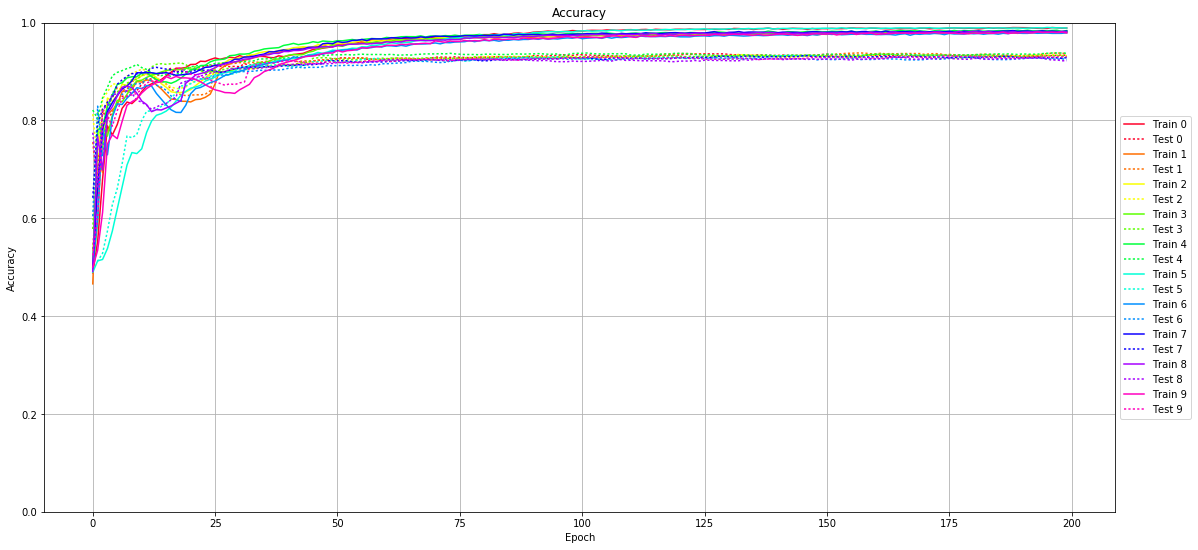

In [17]:
plot_acc(history)

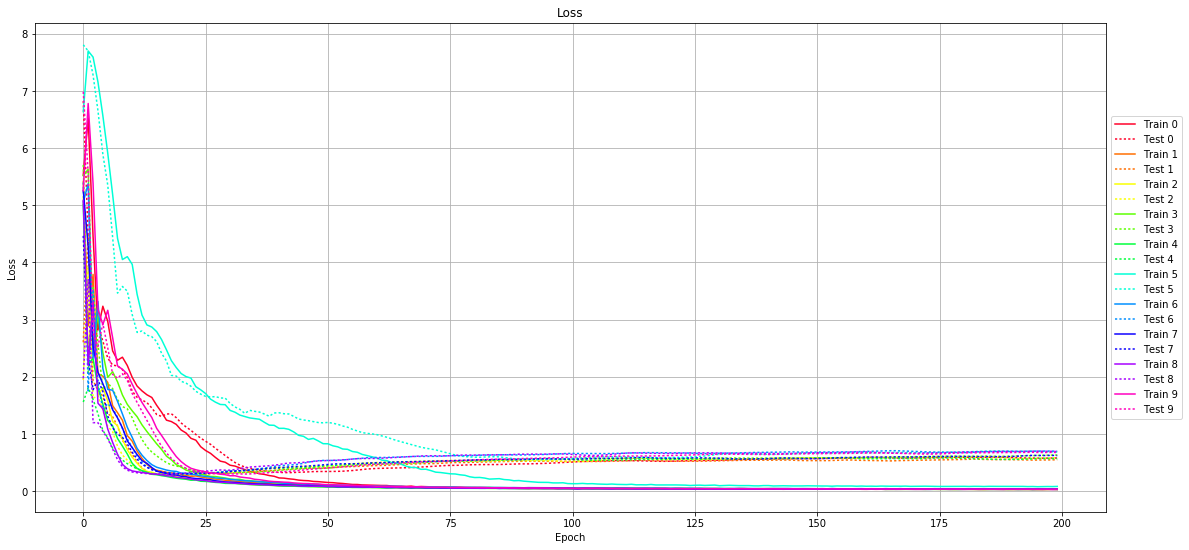

In [18]:
plot_loss(history)

In [19]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


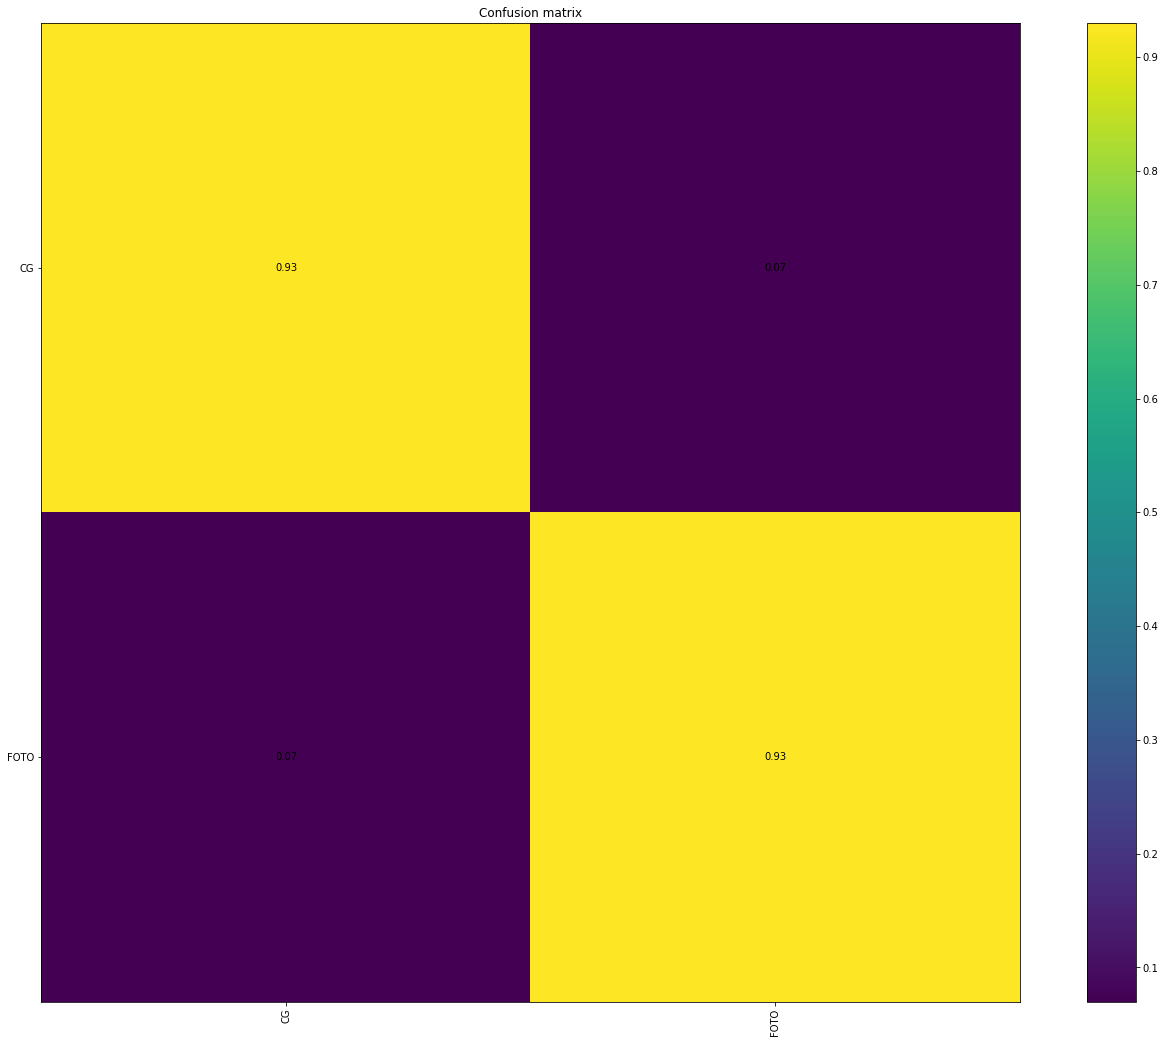

In [20]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()